<a href="https://colab.research.google.com/github/mitosagi/puzzdra-nnsolver/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 15puzzleソルバ
人間にとって直感的な解法を使用して15パズルを解きます。

In [124]:
import numpy as np

board_x = 6
board_y = 5

# Creating a 4x4 array with numbers 1 to 16 in order
ordered_puzzle = np.arange(1, board_y*board_x+1).reshape(board_y, board_x)

# Creating a 4x4 array with numbers 1 to 16 in random order
random_puzzle = np.random.permutation(board_y*board_x) + 1
random_puzzle = random_puzzle.reshape(board_y, board_x)

ordered_puzzle, random_puzzle

(array([[ 1,  2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11, 12],
        [13, 14, 15, 16, 17, 18],
        [19, 20, 21, 22, 23, 24],
        [25, 26, 27, 28, 29, 30]]),
 array([[ 4, 11, 17, 30, 23,  1],
        [20,  7, 22,  9, 28,  3],
        [24, 25, 10, 14, 19,  5],
        [ 6, 26, 16, 29, 27, 13],
        [12, 18,  8,  2, 15, 21]]))

In [109]:
import matplotlib.pyplot as plt
import IPython
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib import rc

def show_animation(puzzles):
  # Redefine the plot function for animation
  def plot_puzzle_for_animation(frame_num, puzzles, ax):
      """ Plot function for animation. """
      ax.clear()
      ax.matshow(puzzles[frame_num], cmap='viridis')
      for (i, j), value in np.ndenumerate(puzzles[frame_num]):
          ax.text(j, i, int(value), ha='center', va='center', color='white')
      ax.set_xticks([])  # Remove x-axis ticks
      ax.set_yticks([])  # Remove y-axis ticks

  # Create a figure and axes
  fig, ax = plt.subplots()

  # Create an animation

  rc('animation', html='jshtml')
  ani = FuncAnimation(fig, plot_puzzle_for_animation, frames=len(puzzles), fargs=(puzzles, ax), interval=50, repeat=True)
  ani.save("move.gif")
  IPython.display.Image("move.gif", format='png')
  return ani

  # # Convert the animation to HTML5 video and display it
  # # HTML(ani.to_html5_video())
  # HTML(ani.to_jshtml())

In [110]:
from queue import Queue

def bfs_find_path_quadrant(start, end, obstacle_matrix):
    """ Perform BFS to find the shortest path from a starting point to an end point, considering an obstacle matrix.
        Redefine directions as per the mathematical quadrant system (x+ = 0, y+ = 1, x- = 2, y- = 3). """
    size_y, size_x = obstacle_matrix.shape
    visited = np.full((size_y, size_x), False)  # Initialize visited array
    parent = np.full((size_y, size_x, 2), -1)  # To store the parent of each node
    q = Queue()

    # Redefine directions: x+ (Right) = 0, y+ (Down) = 1, x- (Left) = 2, y- (Up) = 3
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    direction_mapping = {(dx, dy): d for d, (dx, dy) in enumerate(directions)}

    # Start from the given position
    q.put(start)
    visited[start] = True

    while not q.empty():
        current = q.get()

        if current == end:
            # Reconstruct the path
            path = []
            while current != start:
                prev = parent[current[0], current[1]]
                prev_pos, direction = prev[0], prev[1]
                path.append(direction)
                current = (prev_pos // size_x, prev_pos % size_x)
            return path[::-1]

        # Check all four directions
        for dx, dy in directions:
            next_pos = (current[0] + dx, current[1] + dy)

            if 0 <= next_pos[1] < size_x and 0 <= next_pos[0] < size_y and not visited[next_pos] and obstacle_matrix[next_pos] == 0:
                visited[next_pos] = True
                parent[next_pos[0], next_pos[1]] = (current[0] * size_x + current[1], direction_mapping[(dx, dy)])
                q.put(next_pos)

    return []  # Return empty path if no path is found

# Define the obstacle matrix for a 5x6 board (0 = no obstacle, 1 = obstacle)
obstacle_matrix_5x6 = np.zeros((board_y, board_x), dtype=int)
obstacle_matrix_5x6[2, 0] = 1
obstacle_matrix_5x6[2, 1] = 1
print(obstacle_matrix_5x6)

print([bfs_find_path_quadrant((i // board_x, i % board_x), (2, 0), obstacle_matrix_5x6) for i in [0]][0])

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
[]


In [111]:
def move_tile(puzzle, number, direction):
    """ Move the '30' tile in the specified direction on the puzzle board.
        Directions: 0 = Right, 1 = Down, 2 = Left, 3 = Up. """
    size_y, size_x = puzzle.shape
    # Find the position of the 'number' tile
    y, x = np.where(puzzle == number)
    if y.size == 0 or x.size == 0:
        return puzzle  # Return the original puzzle if 'number' is not found

    y, x = y[0], x[0]  # Extract the coordinates

    # Calculate the new position based on the direction
    if direction == 0 and x < size_x - 1:  # Right
        new_x, new_y = x + 1, y
    elif direction == 1 and y < size_y - 1:  # Down
        new_x, new_y = x, y + 1
    elif direction == 2 and x > 0:  # Left
        new_x, new_y = x - 1, y
    elif direction == 3 and y > 0:  # Up
        new_x, new_y = x, y - 1
    else:
        return puzzle  # Return the original puzzle if the move is not valid

    # Swap the tiles
    new_puzzle = puzzle.copy()
    new_puzzle[y, x], new_puzzle[new_y, new_x] = new_puzzle[new_y, new_x], new_puzzle[y, x]
    return new_puzzle

In [112]:
def rich_move_tile(puzzles, current_puzzle, start_pos, end_pos, obstacle):
  start_n = current_puzzle[start_pos]
  tile_move = bfs_find_path_quadrant(start_pos, end_pos, obstacle)

  for i in tile_move:
    next_puzzle = move_tile(current_puzzle, start_n, i)
    next_start_pos = tuple(np.argwhere(next_puzzle == start_n)[0])

    hand_obstacle = copy.deepcopy(obstacle)
    hand_obstacle[start_pos] = 1

    hand_pos = tuple(np.argwhere(current_puzzle == board_y*board_x)[0])
    hand_move = bfs_find_path_quadrant(hand_pos, next_start_pos, hand_obstacle)
    for j in hand_move:
      current_puzzle = move_tile(current_puzzle, board_y*board_x, j)
      puzzles.append(current_puzzle)

    current_puzzle = move_tile(current_puzzle, board_y*board_x, (i+2)%4)
    puzzles.append(current_puzzle)
    start_pos = tuple(np.argwhere(current_puzzle == start_n)[0])
  return current_puzzle

In [113]:
def possible_moves_with_obstacle(puzzle, position, obstacle_matrix):
    """ Find the possible moves from a given position in the puzzle, considering an obstacle matrix. """
    size_y, size_x = puzzle.shape
    y, x = position
    moves = []

    # Directions: 0 = Right, 1 = Down, 2 = Left, 3 = Up
    if x < size_x - 1 and obstacle_matrix[y, x + 1] == 0:  # Right
        moves.append(0)
    if y < size_y - 1 and obstacle_matrix[y + 1, x] == 0:  # Down
        moves.append(1)
    if x > 0 and obstacle_matrix[y, x - 1] == 0:  # Left
        moves.append(2)
    if y > 0 and obstacle_matrix[y - 1, x] == 0:  # Up
        moves.append(3)

    return moves

In [114]:
def sort_puzzle_by_distance(puzzle, target_position, obstacle_matrix):
  """ Sort the tiles which are multiples of 5 in the puzzle based on the Manhattan distance from the target position,
      considering the obstacle matrix. """
  def sort_puzzle_by_distance_small(puzzle, target_position, obstacle_matrix, rem):
      size_y, size_x = puzzle.shape
      multiples_of_five = []
      positions = []

      # Extract multiples of 5 and their positions, excluding obstacles
      for y in range(size_y):
          for x in range(size_x):
              if puzzle[y, x] % 5 == rem and obstacle_matrix[y, x] == 0:
                  multiples_of_five.append(puzzle[y, x])
                  positions.append((y, x))

      # Sort the multiples of five
      multiples_of_five.sort()

      # Calculate Manhattan distances and sort positions based on it
      distances = [abs(y - target_position[0]) + abs(x - target_position[1]) for y, x in positions]
      sorted_positions = [pos for _, pos in sorted(zip(distances, positions))]

      # Create a new puzzle with sorted values
      new_puzzle = puzzle.copy()
      for pos, value in zip(sorted_positions, multiples_of_five):
          new_puzzle[pos] = value

      return new_puzzle

  puzzle = sort_puzzle_by_distance_small(puzzle, target_position, obstacle_matrix, 0)
  puzzle = sort_puzzle_by_distance_small(puzzle, target_position, obstacle_matrix, 1)
  puzzle = sort_puzzle_by_distance_small(puzzle, target_position, obstacle_matrix, 2)
  puzzle = sort_puzzle_by_distance_small(puzzle, target_position, obstacle_matrix, 3)
  puzzle = sort_puzzle_by_distance_small(puzzle, target_position, obstacle_matrix, 4)
  return puzzle

1
2
3
4
5
6
7
8
10
11
13
14
16
17
19
20
22
23
25
27
28
29


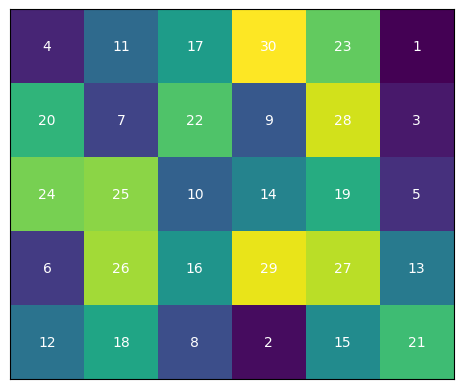

In [126]:
import copy

current_puzzle = copy.deepcopy(random_puzzle)
puzzles = [current_puzzle]

template_puzzle = [[ 7,10,13,29,28,22],
                   [ 8,11,14,30,27,23],
                   [ 9,12,15,25,26,24],
                   [ 4, 5, 6,21,20,19],
                   [ 1, 2, 3,18,17,16]]
template_puzzle = np.array(template_puzzle, dtype=int)
tile_obstacle = np.zeros((board_y, board_x), dtype=int)

n = 1
while n < board_y*board_x:
  step_pos = tuple(np.argwhere(template_puzzle == n)[0])
  next_step_pos = tuple(np.argwhere(template_puzzle == n + 1)[0])

  no_hand_obstacle = copy.deepcopy(tile_obstacle)
  hand_pos = tuple(np.argwhere(current_puzzle == board_y*board_x)[0])
  no_hand_obstacle[hand_pos] = 1
  current_puzzle = sort_puzzle_by_distance(current_puzzle, step_pos, no_hand_obstacle)
  puzzles.append(current_puzzle)
  print(n)

  next_tile_obstacle = copy.deepcopy(tile_obstacle)
  next_tile_obstacle[step_pos] = 1
  tile_pos = tuple(np.argwhere(current_puzzle == n)[0])
  predict = possible_moves_with_obstacle(template_puzzle, next_step_pos, next_tile_obstacle)
  if(len(predict) > 1) or n >= board_y*board_x - 4:
    current_puzzle = rich_move_tile(puzzles, current_puzzle, tile_pos, step_pos, tile_obstacle)
    tile_obstacle[step_pos] = 1
    n = n + 1
  else:
    template_puzzle_p = move_tile(template_puzzle, n + 1, predict[0])
    template_puzzle_pp = move_tile(template_puzzle_p, n + 1, predict[0])
    next_step_pos_p = tuple(np.argwhere(template_puzzle_p == n + 1)[0])
    next_step_pos_pp = tuple(np.argwhere(template_puzzle_pp == n + 1)[0])
    next_tile_pos = tuple(np.argwhere(current_puzzle == n + 1)[0])
    if (next_tile_pos[0] == step_pos[0] or next_tile_pos[0] == next_step_pos_p[0]) and\
        (next_tile_pos[1] == step_pos[1] or next_tile_pos[1] == next_step_pos_p[1]):
      current_puzzle = rich_move_tile(puzzles, current_puzzle, next_tile_pos, next_step_pos_pp, tile_obstacle)
    tile_pos = tuple(np.argwhere(current_puzzle == n)[0])
    current_puzzle = rich_move_tile(puzzles, current_puzzle, tile_pos, next_step_pos, tile_obstacle)
    next_tile_pos = tuple(np.argwhere(current_puzzle == n + 1)[0])
    next_tile_obstacle = copy.deepcopy(tile_obstacle)
    next_tile_obstacle[next_step_pos] = 1
    current_puzzle = rich_move_tile(puzzles, current_puzzle, next_tile_pos, next_step_pos_p, next_tile_obstacle)
    next_tile_pos = tuple(np.argwhere(current_puzzle == n + 1)[0])
    current_puzzle = rich_move_tile(puzzles, current_puzzle, next_tile_pos, next_step_pos, tile_obstacle)
    tile_obstacle[step_pos] = 1
    tile_obstacle[next_step_pos] = 1
    n = n + 2

show_animation(puzzles)
